In [1]:
# to generate result sheet autoly
import pandas as pd 
import numpy as np 
import scipy
# import xlrd 
import sklearn

from Gibbs_model_probit import Gibbs_sampling
from sklearn.gaussian_process import GaussianProcessRegressor

from sklearn.model_selection import train_test_split
from scipy.stats import multivariate_normal
from utils import baseline_lr,baseline_esnet,baseline_justmean
from utils import baseline_LogitElsnet,baseline_justmode,baseline_random,baseline_LogitLR,baseline_RanForest,baseline_Gibbs_zhe,baseline_SVM
from utils import baseline_LogitElsnet_leaveone,baseline_LogitLR_leaveone,baseline_SVM_leaveone
from utils import logis_regression_5,kernel_svm_regression_5,random_forest_regression_5,gpr_regression_5,logis_lasso_regression_5
from sklearn.model_selection import KFold
from scipy.stats import binom 
from scipy.stats import norm
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestClassifier
from tqdm import trange
from Gibbd_zhe import GibbsSampling3
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import LeaveOneOut
import time
from sklearn.preprocessing import StandardScaler
# from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, Matern
from sklearn.linear_model import LogisticRegression
from utils_new import logis_regression_5_new,logis_lasso_regression_5_new,gpr_regression_5_new,kernel_svm_regression_5_new


In [2]:
# data_loading 
np.random.seed(123)

# data_table = pd.read_csv('../data/processed/all_feature_p1_lip_total_single.csv')
data_table_cont = pd.read_csv('../data/processed/all_feature_p1_lip_specie.csv')
data_table_binary = pd.read_csv('../data/processed/all_feature_p1_lip_specie_binary.csv')


data_table_temp = pd.read_csv('../data/processed/all_feature_p1_spicie_cont_single.csv')
# data_table_binary = pd.read_csv('../data/processed/all_feature_p1_spicie_binary_single.csv')

data_table_binary_standard = pd.read_csv('../data/processed/all_feature_p1_spicie_binary_standard_single.csv')




In [3]:
# last seven columns are labels
all_feature_cont = data_table_cont.iloc[:,1:-7]
all_feature_binary = data_table_binary.iloc[:,1:-7]
all_feature_binary_standard = data_table_binary_standard.iloc[:,1:-7]
data_table_temp = data_table_temp.iloc[:,1:-7]
all_feature_cont
# data_table_temp

,lip_Sph(d16:1)_27,lip_Sph(d18:1)_27,lip_Sph(d18:2)_27,lip_S1P(d16:1)_6,lip_S1P(d18:0)_6,lip_S1P(d18:1)_6,lip_S1P(d18:2)_6,lip_Cer(d18:0/16:0)_3,lip_Cer(d18:0/18:0)_3,lip_Cer(d18:0/20:0)_3,...,gene_FGFR2_Del_2,gene_ESR1_Amp_2,gene_ESR1_Del_2,gene_CDK6_Amp_2,gene_CDK6_Del_2,gene_AR_Amp_2,gene_AR_Del_2,gene_MSH2_Amp_2,gene_MSH2_Del_2,gene_TMPRSS2-ERG_fussion_2
0,-1.001074,-0.571053,-0.943436,-0.562106,0.855298,1.068884,0.820564,-1.451571,-1.636620,-1.323020,...,0,0,0,0,0,0,0,0,0,1
1,-1.090721,-0.815569,-1.344245,0.703951,0.879841,1.386983,2.282040,1.083168,0.317117,0.143921,...,0,0,0,0,0,0,0,0,0,0
2,-0.631061,-0.050403,-0.683378,0.859897,0.866382,1.445685,3.274926,0.041372,-0.714934,-1.495017,...,0,0,0,0,0,0,0,0,0,0
3,-0.647597,0.062924,-0.401852,-1.027191,1.431866,1.059986,0.302602,-0.106702,0.184617,0.722072,...,0,0,0,0,0,0,0,0,0,0
4,-0.709775,-0.621352,-0.730621,-0.349646,0.550500,0.477154,1.641278,-0.896900,0.094754,-0.867487,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,0.126322,0.209674,0.490797,0.425272,1.002470,0.711640,0.149553,-0.376240,0.473775,1.114981,...,0,0,0,0,0,0,0,0,0,0
67,0.211905,-0.001538,0.068290,0.621367,-0.256764,-0.346590,0.188325,-0.140564,-0.137942,-0.372518,...,0,0,0,0,0,0,0,0,0,0
68,1.082877,-0.348247,0.121666,0.048357,0.526607,1.046721,0.243237,0.333054,-0.046098,-0.121764,...,0,0,0,0,0,0,0,0,0,0
69,1.874614,0.248793,-1.023960,-2.083800,-0.355171,-0.324503,-0.681583,0.066834,-0.874029,-0.795122,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# P1(mHSPC) testtosterone suppression failure: CER(ceramide), DG(diacylglycerol), TG(triaclyglycerol)
# P2(mCRPC) overall survival:  CER(ceramide), Sph(Sphingosine), Acylcarnitine(acylcarnitine)
def feature_filter(df):
    all_feature = list(df)
    feature_dict = {}

    feature_dict['TG'] = [item for item in all_feature if 'lip_TG' in item]
    feature_dict['Cer'] = [item for item in all_feature if 'lip_Cer' in item]
    feature_dict['DG'] = [item for item in all_feature if 'lip_DG' in item]

    feature_dict['ATM'] = [item for item in all_feature if 'ATM_SNP' in item]
    feature_dict['BRCA1'] = [item for item in all_feature if 'BRCA1_SNP' in item]
    feature_dict['BRCA2'] = [item for item in all_feature if 'BRCA2_SNP' in item]
    feature_dict['CHEK2'] = [item for item in all_feature if 'CHEK2_SNP' in item]


    feature_dict['gene'] = feature_dict['ATM'] + feature_dict['BRCA1'] + feature_dict['BRCA2'] + feature_dict['CHEK2']

    # ['DG','Cer','gene'] # optimal feature groups for survial prediction 
    return feature_dict['gene'] + feature_dict['Cer'] + feature_dict['DG']

feature_ours  = feature_filter(data_table_binary)# binary +  sig model

In [5]:
def get_signature(df):
    all_feature = list(df)
    feature_dict = {}
    feature_dict['Cer'] = [item for item in all_feature if 'lip_Cer(d18:1/24:1)' in item]
    feature_dict['Sph'] = [item for item in all_feature if 'lip_Sph(d18:2)' in item]
    feature_dict['PI'] = [item for item in all_feature if 'lip_PI(16:0/16:0)' in item]

    feature_dict['ATM'] = [item for item in all_feature if 'ATM_SNP' in item]
    feature_dict['BRCA1'] = [item for item in all_feature if 'BRCA1_SNP' in item]
    feature_dict['BRCA2'] = [item for item in all_feature if 'BRCA2_SNP' in item]
    feature_dict['CHEK2'] = [item for item in all_feature if 'CHEK2_SNP' in item]


    feature_dict['gene'] = feature_dict['ATM'] + feature_dict['BRCA1'] + feature_dict['BRCA2'] + feature_dict['CHEK2']

    feature_sig = feature_dict['Cer'] + feature_dict['Sph'] + feature_dict['PI'] 
    feature_sig_gene = feature_dict['Cer'] + feature_dict['Sph'] + feature_dict['PI'] + feature_dict['gene']

    return feature_sig, feature_sig_gene 

feature_sig, feature_sig_gene  = get_signature(data_table_cont) # standard sig model
# feature_dict_conti
feature_sig_binary, feature_sig_gene_binary  = get_signature(data_table_binary)# binary +  sig model
# print(feature_dict_conti,feature_dict_binary)

# print(feature_sig_conti, feature_sig_binary)

In [6]:
from sklearn.metrics import roc_curve
rand_seed=52

X=  data_table_cont[feature_sig].values
np.random.seed(rand_seed)
train_idx = np.random.choice(range(X.shape[0]), int(X.shape[0]*0.60), replace=False)
test_idx = np.setdiff1d(range(X.shape[0]), train_idx)

def ROC_evaluate(X,Y,l1_ratio=0.1):

    X_train = X[train_idx,:]
    Y_train = Y[train_idx]

    X_test = X[test_idx,:]
    Y_test = Y[test_idx]

    clf = LogisticRegression(random_state=0,penalty='elasticnet',solver='saga',l1_ratio=l1_ratio
    ).fit(X_train, Y_train)
    
    test_score = clf.score(X_test,Y_test)
    y_pred_prob = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
    auc = roc_auc_score(Y_test, y_pred_prob)

    print('test_score:',test_score)
    print('auc:',auc)
    return fpr, tpr, thresholds


X_list = [data_table_cont[feature_sig].values, data_table_cont[feature_sig_gene].values, data_table_binary[feature_sig_binary].values, data_table_binary[feature_ours].values]
X_names = ['3-lip','3-lip+gene','3-lip+ bin-split binary','proposed ML model']
l1_list   = [0.15,0.15,0.05,0.15]

target ='1= death; 0=alive'
# X = data_table[feature_sig].values
Y = data_table_cont[target].values

fpr_tpr_list = []

for i in range(len(X_list)):
    X = X_list[i]
    print(X_names[i])
    fpr, tpr, thresholds = ROC_evaluate(X,Y,l1_ratio=l1_list[i])
    fpr_tpr_list.append([fpr, tpr, thresholds])



3-lip
test_score: 0.5862068965517241
auc: 0.5528846153846154
3-lip+gene
test_score: 0.5862068965517241
auc: 0.5576923076923077
3-lip+ bin-split binary
test_score: 0.5517241379310345
auc: 0.5
proposed ML model
test_score: 0.6896551724137931
auc: 0.7115384615384616


f:\anaconda\conda\envs\pt\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [7]:
# plot the ROC curve
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
for i in range(len(fpr_tpr_list)):
    fpr, tpr, thresholds = fpr_tpr_list[i]
    plt.plot(fpr, tpr, label=X_names[i])


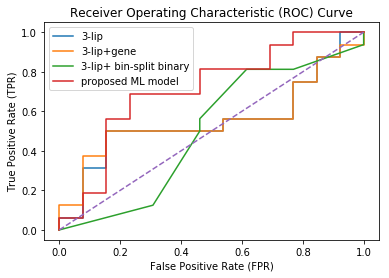

In [10]:
for i in range(len(fpr_tpr_list)):
    fpr, tpr, thresholds = fpr_tpr_list[i]
    plt.plot(fpr, tpr, label=X_names[i])
plt.plot([0, 1], [0, 1], '--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend()
# save as pdf
plt.savefig('ROC.pdf',bbox_inches='tight')
plt.show()


In [9]:
plt.show()